<a href="https://colab.research.google.com/github/SU-sumico/dlj/blob/main/2_cnn_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目的
* CIFAR10データセットと畳み込みニューラルネットワーク（CNN）を用いて10クラスの画像分類を行う。
* データ拡張（Data Augmentation）を行う。
* 学習中のチェックポイントの作成と学習を途中から再開する。

準備
* GPUを用いて処理を行うために、上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください。

使用するデータセット
* データセットは、32ピクセル×32ピクセルサイズ、RGBカラーの6万枚の画像が含まれており、猫や犬など10種類のクラスに分類されています。
* データセットの公式HP: https://www.cs.toronto.edu/~kriz/cifar.html

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


プログラムで使用するライブラリをインポート

In [2]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow 2.x系を使用
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# TensorFlowのバージョン
print(tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# matplotlib の出力をノートブック上に描画するための設定
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0


CIFAR-10データセット: Kerasの datasets.cifar10.load_data() を使ってデータを読み込みます。

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


読み込んだデータセットの内容を確認します。

In [4]:
print('データ型')
print('x_train type:', type(x_train), x_train.dtype)
print('y_train type:', type(y_train), y_train.dtype)
print('x_test type:', type(x_test), x_test.dtype)
print('y_test type:', type(y_test), y_test.dtype)

print('\n行数, 列数')
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

データ型
x_train type: <class 'numpy.ndarray'> uint8
y_train type: <class 'numpy.ndarray'> uint8
x_test type: <class 'numpy.ndarray'> uint8
y_test type: <class 'numpy.ndarray'> uint8

行数, 列数
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


画像データの仕組み
* データ型はいずれもnumpy.ndarray（配列）https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html
符号なし整数です。
* 訓練データは50,000件、評価データは10,000件あります。
* 画像のデータは、ピクセルごとの色情報の集まりです。
* データの形状は(32, 32, 3) でした。32ピクセル×32ピクセル分、RGBチャンネル（赤、緑、青の3種類）の値が格納されています。
* RGBはそれぞれ0〜255の値で表します。
* データの形状は、色情報がRGBA（RGB+透明度）の場合は(32, 32, 4)、モノクロの場合は(32, 32, 1) になります。
* 1枚目のデータの中身を確認します。

In [5]:
# 50000のうち一枚目の画像のデータ
print(x_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


最初の要素の [59, 62, 63] は、R（赤）が59、G（緑）が62、B（青）が63という意味です。

画像の内容
* 画像を見てみます。
* 画像は plt.imshow() を使って表示します。

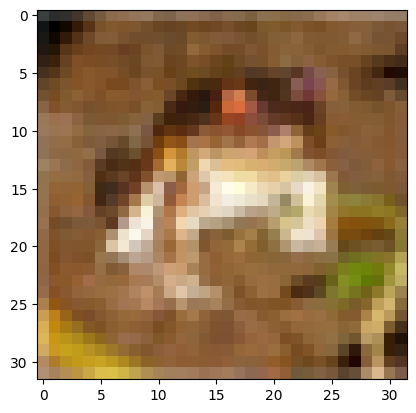

In [6]:
plt.imshow(x_train[0])
plt.show()

ラベル
* ラベルの内容も確認します。
* このデータセットに用意されているクラスは10種類、ラベルにはクラスを表す数値が格納されています。

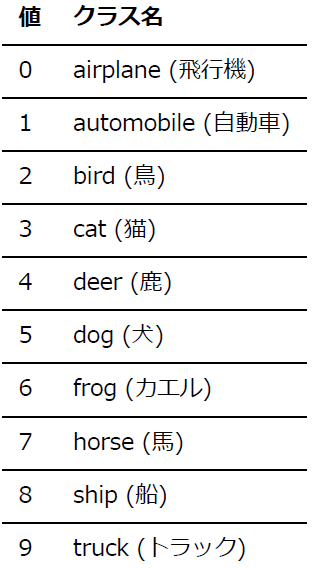

数字では分かりづらいのでクラス名を定義します。

In [7]:
# カテゴリ値とクラス名の対応付け
class_names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# クラス数
num_classes = len(class_names) # 10

訓練データ1枚⽬のラベルを確認します。

In [8]:
# 最初のデータに対応するラベル
y_train[0]

array([6], dtype=uint8)

1枚目の画像のラベルは「6」でした。「6」に対応するクラス名を表示します。

In [9]:
# クラス名を表示
class_names[y_train[0, 0]]

'frog'

1枚目の画像には「カエル」のラベルがつけられていました。他の画像も見てみます。

In [10]:
# 画像を並べて表示する関数
def show_img(x, y):
  plt.clf()

  # サイズ
  plt.figure(figsize=(10, 8))

  # 30枚の画像を表示
  for i in range(0, 30):
    plt.subplot(5, 6, i+1)

    # クラス名を表示
    plt.title(class_names[y[i]], fontsize=8)

    # 画像を表示
    fig = plt.imshow(x[i])

    # メモリを消す
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

<Figure size 640x480 with 0 Axes>

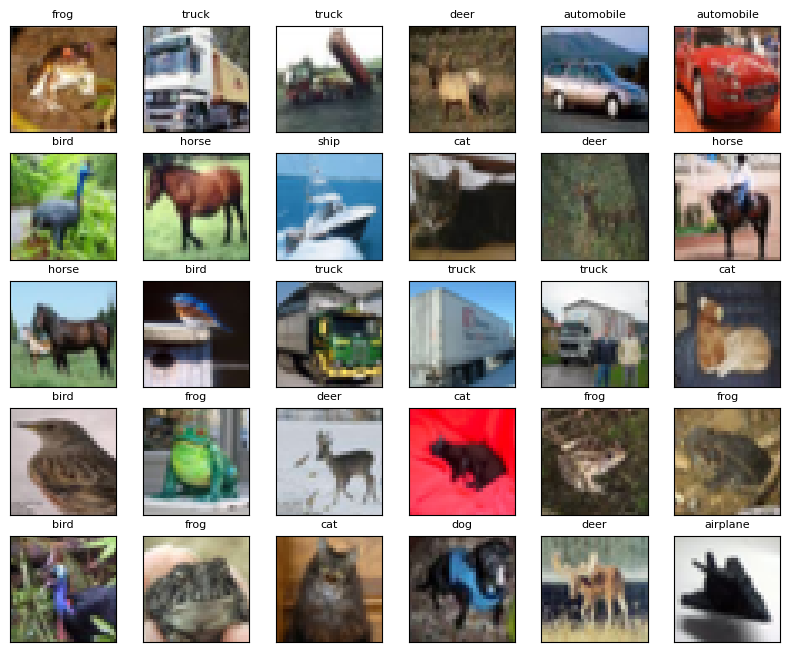

In [11]:
show_img(x_train, y_train.flatten())

データの分布
* 訓練データのクラスの分布を確認します。

(array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

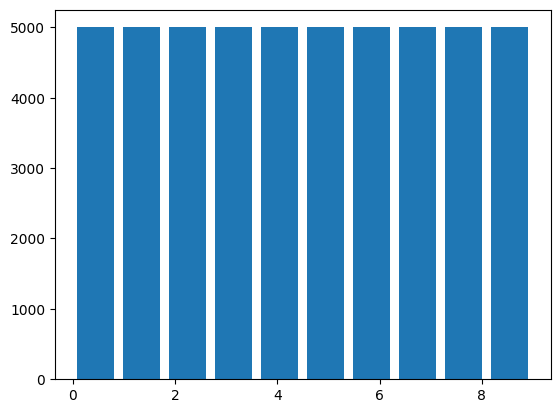

In [12]:
plt.hist(y_train, bins=num_classes, rwidth=0.8)

すべてのクラスが5,000件ずつ含まれており、偏りはありません。

正規化
* 各色の値は0〜255でした。
* このままでは値の範囲が広く学習に時間がかかるため、0〜1の範囲に変換します。

In [13]:
# 0～1の範囲に変換するため, 255で割る
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train[0])

[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  [0.67843137 0.48235294 0.16470588]


データの分割
* 訓練データのうち2割を検証データとします。

In [14]:
# 訓練データ8割、検証データ2割に分割
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2,
random_state=777)

print('訓練データ件数：', len(x_train))
print('検証データ件数：', len(x_val))

訓練データ件数： 40000
検証データ件数： 10000


(array([4050., 4016., 3958., 4010., 3993., 3969., 4075., 3976., 3984.,
        3969.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

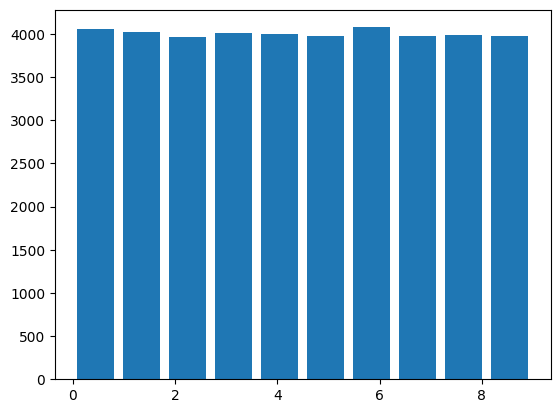

In [15]:
# データの分布
plt.hist(y_train, bins=num_classes, rwidth=0.8)

カテゴリ変数のone-hotベクトル化
* ラベルには0〜9のカテゴリ変数が格納されていました。
* カテゴリ変数はそのままでは扱えませんので、one-hotベクトルに変換します。
* one-hotベクトルとは、該当するクラスのインデックスのみ 1、残りは 0 が格納されている配列です。
* 例:
[1,0,0,0,0,0,0,0,0,0] # 0:airplane;
[0,1,0,0,0,0,0,0,0,0] # 1:automobile
* tf.keras.utils.to_categorical() はカテゴリ変数をone-hotベクトルに変換する関数です。

In [16]:
# ラベルのone-hotベクトル化
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # 訓練データのラベル
y_val = tf.keras.utils.to_categorical(y_val, num_classes) # 検証データのラベル
y_test = tf.keras.utils.to_categorical(y_test, num_classes) # 評価データのラベル

In [17]:
print(y_train[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


データ拡張
* 学習データとなる画像を少しずつ加工しながら水増しすることで、データ量の増加と汎化性能の向上が期待できます。
* Kerasにはデータ拡張のための機能 ImageDataGenerator が用意されています。
https://keras.io/ja/preprocessing/image/
* 回転やずらす割合などを指定すると、ランダムに画像を加工します。
* 加工には注意点が必要です。映っているものの「角度」や「向き」に意味がある場合は、回転や反転は行いません。
* 例えば、上矢印と下矢印の画像を分類する場合、上下反転してしまうと意味が変わってしまいます。
* 同様に、色に意味がある場合は、色を大きく加工してはいけません（信号機の画像など）

In [18]:
# バッチサイズを決める
batch_size = 64

In [19]:
# ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             zoom_range=0.1,
                             channel_shift_range=0.05)

# 訓練データをデータ拡張
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=False)

<Figure size 640x480 with 0 Axes>

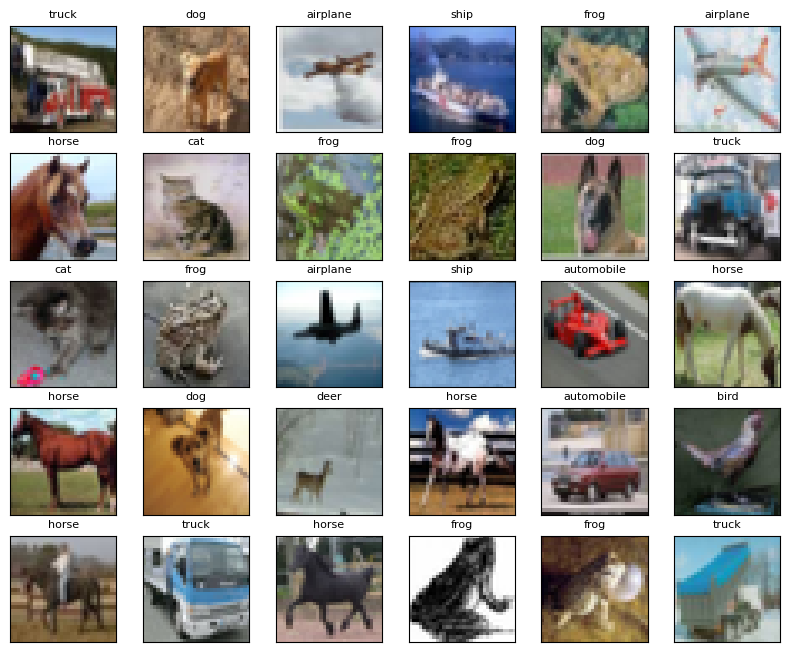

In [20]:
# 変更前の画像
show_img(x_train, [np.argmax(y) for y in y_train])

<Figure size 640x480 with 0 Axes>

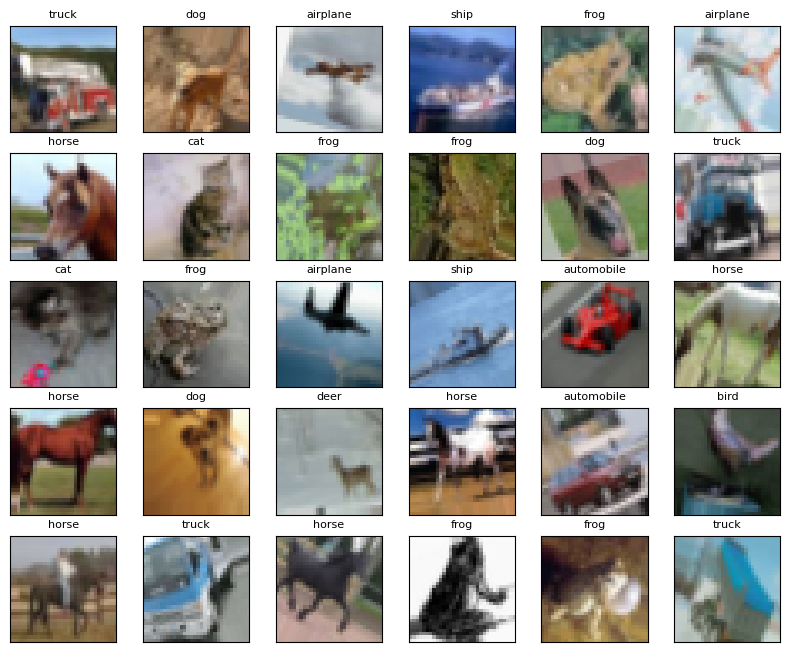

In [21]:
# データ拡張した画像
x, y = next(train_generator) # xがデータ拡張した画像、yがラベル
show_img(x, [np.argmax(yi) for yi in y])

モデルの定義
* 画像を扱うタスクでは、畳み込みニューラルネットワーク(Convolutional Neural Network︓CNN)が有効とされています。
* 畳み込みニューラルネットワークとは「畳み込み層」と「プーリング層」を重ねたニューラルネットワークです。
* 畳み込み層では小さなフィルタ（カーネル）を使って入力の特徴を抽出します。
* プーリング層はMax（最大値）プーリングやAverage（平均）プーリングといった種類があり、情報の最大値や平均値を求めることで情報を集約します。
* 画像を扱う場合は特徴をより際⽴たせたいので、Maxプーリングを用いることが多いです。

隠れ層
* 畳み込み層 layers.Conv2D とMaxプーリング層 layers.MaxPool2D をいくつか重ねます。
* 最初の層には入力の形状 input_shape を指定する必要がありますので、今回のデータの形状である (32, 32, 3) を指定します。
* 畳み込み層では、カーネルのサイズ(kernel_size)とカーネルをどれだけずらすかを表すストライド(strides)を指定します。
* また、パディング(padding)を指定することで、畳み込みによって画像が小さくなりすぎたり、画像の端の情報が反映されにくくなるのを防ぎます。

出⼒層
* このモデルには最後に分類結果を出力させたいので、出力層には全結合層 Dense を使用します。
* 隠れ層の出力は3次元ですので、Dense 層に渡す前に、1次元に変換する（平坦化する）必要があります。そこで、Dense 層の前に平坦化を行う layers.Flatten 層を挟みます。
* 最後の層の出力はそれぞれのクラスに該当する確率にしたいので、活性化関数は softmax を使用します。
* 今回は 10 クラスに分類するので、出力層の最後の層のユニット数は 10 を指定します。
* まずは小さな畳み込みニューラルネットワークを作成します。

In [22]:
# モデルの定義
model = tf.keras.Sequential([

    # --- 隠れ層/Hidden layer --- #

    # 畳み込み層/Convolutional layer
    layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)),

    # Maxプーリング層/Max pooling layer
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    # 畳み込み層/Convolutional layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),

    # Maxプーリング層/Max pooling layer
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    # 平坦化/Flattening
    layers.Flatten(),

    # --- 出力層/Output layer --- #

    # 結合層/Connected layer
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),

])

# モデルの構造を出力
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               5

モデルのコンパイル
* 最適化アルゴリズムは「adam」を使用します。
* カテゴリ分類ですので、損失関数は「categorical_crossentropy」を使用します。
* 評価関数は、どれくらい正しく分類できたかを示す「accuracy」を指定します。

In [23]:
# モデルのコンパイル
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

学習
* エポックごとにモデルを保存するための仕組みがModelCheckpointです。
* 学習を行う:model.fit()やmodel.fit_generator()の、callbacksオプションに指定することで、エポック終了時にモデル（または重み）を保存します。

In [24]:
# 保存先のパス
save_path = '/content/drive/MyDrive/Deep learning/2data/'

# 保存するファイル名
save_filename = 'cifar10_weight_{epoch:02d}.h5'

# チェックポイント
checkpoint = ModelCheckpoint(save_path + save_filename,
                             save_weights_only=True) # 重みだけを保存

ImageDataGeneratorを使った学習
* ImageDataGeneratorを利用して学習を行うには、model.fit_generator()を使います。

In [25]:
# 学習とエポックごとの評価
history = model.fit_generator(train_generator, steps_per_epoch=(len(x_train)//batch_size), epochs=10, validation_data=(x_val,y_val), callbacks=[checkpoint])

Epoch 1/10


<ipython-input-25-386e305d3249>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=(len(x_train)//batch_size), epochs=10, validation_data=(x_val,y_val), callbacks=[checkpoint])


625/625 [==============================] - 44s 54ms/step - loss: 1.6552 - accuracy: 0.3983 - val_loss: 1.3540 - val_accuracy: 0.5131
Epoch 2/10
625/625 [==============================] - 33s 53ms/step - loss: 1.3832 - accuracy: 0.5033 - val_loss: 1.1791 - val_accuracy: 0.5818
Epoch 3/10
625/625 [==============================] - 32s 52ms/step - loss: 1.2865 - accuracy: 0.5429 - val_loss: 1.1129 - val_accuracy: 0.6082
Epoch 4/10
625/625 [==============================] - 39s 63ms/step - loss: 1.2134 - accuracy: 0.5711 - val_loss: 1.1207 - val_accuracy: 0.6031
Epoch 5/10
625/625 [==============================] - 33s 53ms/step - loss: 1.1646 - accuracy: 0.5871 - val_loss: 1.0225 - val_accuracy: 0.6325
Epoch 6/10
625/625 [==============================] - 33s 53ms/step - loss: 1.1228 - accuracy: 0.6039 - val_loss: 1.0787 - val_accuracy: 0.6265
Epoch 7/10
625/625 [==============================] - 33s 54ms/step - loss: 1.0900 - accuracy: 0.6146 - val_loss: 0.9609 - val_accuracy: 0.6647
Epo

中断した学習を再開する場合は、model.load_weights() で保存済みの重みファイルを読み込みます。

In [26]:
# # 保存したモデルの重みを読み込む
# model.load_weights(save_path + 'cifar10_weight_01.h5')

# # 続きから学習を再開
# history = model.fit_generator(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint])

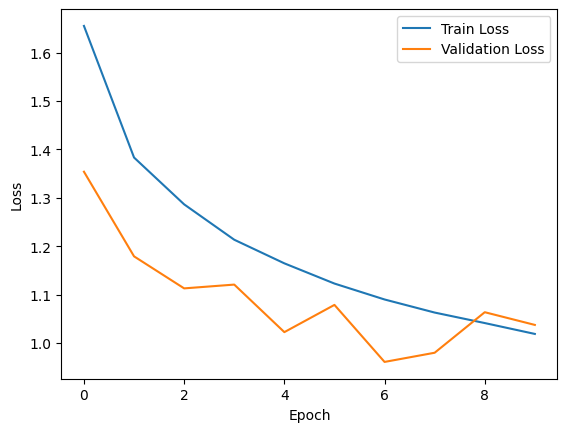

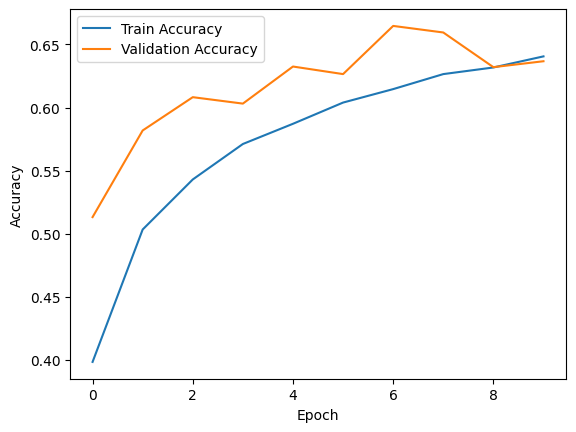

In [27]:
# 学習の推移をグラフ表示
# 損失
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Train Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 正解率
plt.figure()
plt.plot(history.epoch, history.history['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

推論
* テストデータを使って推論を行います。
* 先にテストデータを確認します。

In [28]:
# テストデータのラベル
y_test_flat = [np.argmax(i) for i in y_test]

<Figure size 640x480 with 0 Axes>

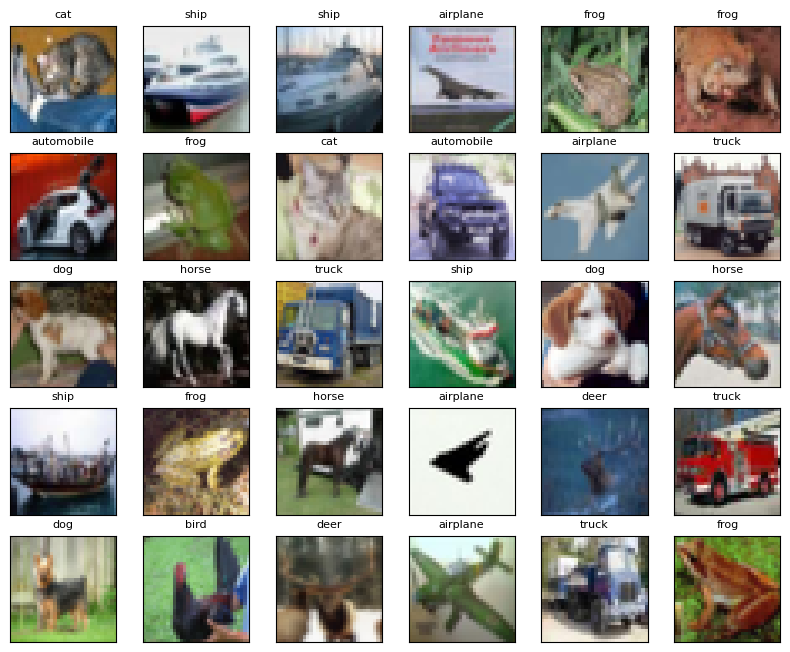

In [29]:
# 画像を表示
show_img(x_test, y_test_flat)

In [30]:
# 推論
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


推論結果
* model.predict()の戻り値は10個の数値です。
* これはインデックスに対応するクラスである確率を表しています。
* 0番目の要素がクラス0（airplane︓飛行機）である確率、1番目の要素がクラス1（automobile︓自動車）である確率 … という具合です。
* 推論結果を見てみます。

In [31]:
np.set_printoptions(suppress=True) # ndarrayをprint()した時に指数表記しない

# 最初のテストデータに対する推論結果
print(y_pred[0])

[0.00966722 0.07816185 0.00915524 0.68281734 0.01308889 0.12885939
 0.02437547 0.00489529 0.02689677 0.02208257]


クラスの分類
* 今回は⼀番確率が高かったクラスに分類します。
* numpy.ndarray の中で⼀番大きい値のインデックスを取得するには、np.argmax() を使用します。

In [32]:
# 最も確率が高いクラスの値
pred_class = np.argmax(y_pred[0])

print('最も確率が高いクラスの値：', pred_class)
print('クラス名：', class_names[pred_class])

最も確率が高いクラスの値： 3
クラス名： cat


他のテストデータはどうだったか見てみます。

In [33]:
# 正解と予測を表示する関数
def show_img_pred(x, y_true, y_p):
  plt.clf()
  plt.figure(figsize=(15, 10))
  for i in range(0, 30):

    title = '[O]' if y_true[i] == y_p[i] else '[X]'
    title += class_names[y_true[i]] + '/' + class_names[y_p[i]]

    plt.subplot(5, 6, i+1)
    plt.title(title, fontsize=8)
    fig = plt.imshow(x[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [34]:
# 確率が高いクラスの値をリストにする
y_pred_flat = [np.argmax(yi) for yi in y_pred]

<Figure size 640x480 with 0 Axes>

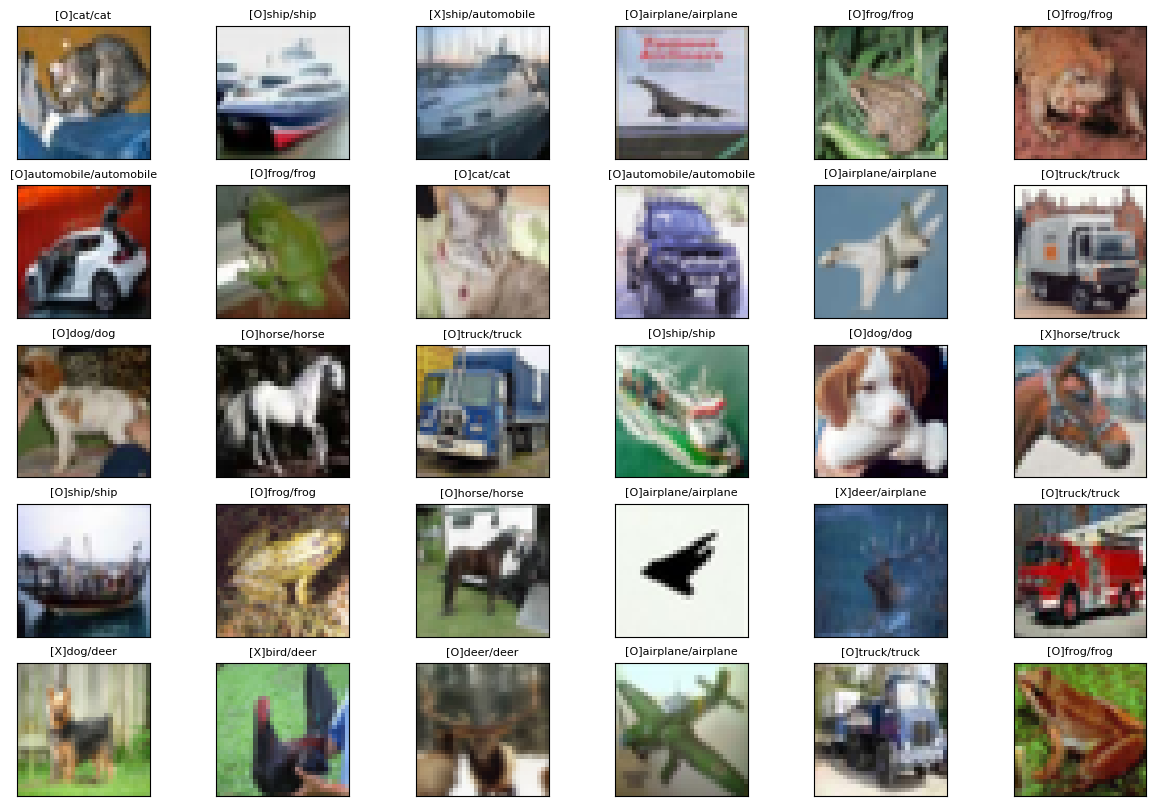

In [35]:
# 正解と予測を表示
show_img_pred(x_test, y_test_flat, y_pred_flat)

評価
* sklearn.metrics.classification_report()を使って、分類の精度を評価します。

In [36]:
# 正解と予測値のクラス名リストを作る
y_test_class_names = [class_names[x] for x in y_test_flat] # 正解のラベル
y_pred_class_names = [class_names[x] for x in y_pred_flat] # 予測結果

# 指標の表示
print(classification_report(y_test_class_names, y_pred_class_names))

              precision    recall  f1-score   support

    airplane       0.65      0.78      0.71      1000
  automobile       0.62      0.90      0.74      1000
        bird       0.78      0.38      0.51      1000
         cat       0.57      0.36      0.44      1000
        deer       0.74      0.45      0.56      1000
         dog       0.70      0.47      0.56      1000
        frog       0.50      0.90      0.64      1000
       horse       0.65      0.79      0.71      1000
        ship       0.84      0.65      0.74      1000
       truck       0.64      0.75      0.69      1000

    accuracy                           0.64     10000
   macro avg       0.67      0.64      0.63     10000
weighted avg       0.67      0.64      0.63     10000



それぞれのクラスが何に誤分類されているのか、混同行列で確認します。

In [37]:
# 混同行列を描画する関数
def plot_confusion_matrix(test_list, pred_list):

  # 混同行列を作成
  cm = confusion_matrix(test_list, pred_list)

  fig, ax = plt.subplots(figsize=(7,7))
  im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=class_names.values(), yticklabels=class_names.values(),

         ylabel='True label',
         xlabel='Predicted label')

  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, cm[i, j],
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")

      # x軸のラベルを回転
      for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=75)

      fig.tight_layout()

      return ax

<Axes: label='<colorbar>'>

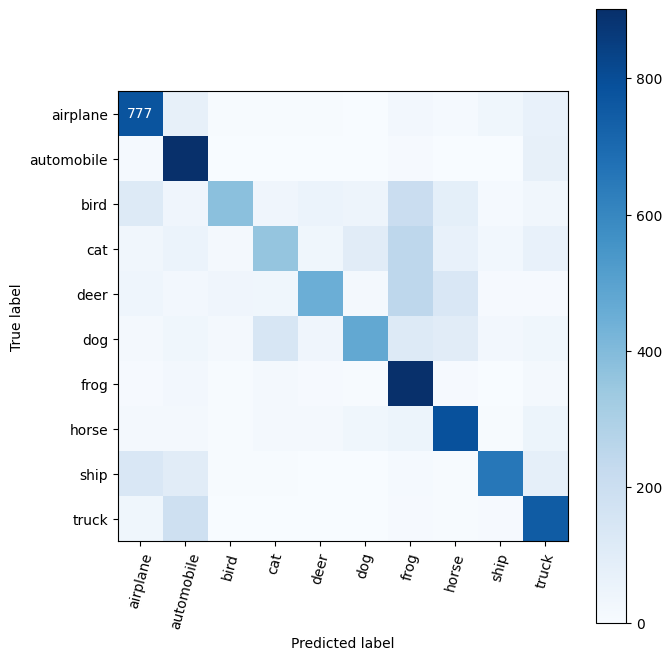

In [38]:
# 混同行列を描画
plot_confusion_matrix(y_test_class_names, y_pred_class_names)

チューニング
* 先ほどのモデルは良い精度とは言えませんでした。
* モデルが小さすぎてモデルの表現力が足りていないと考えられますので、もう少し深いニューラルネットワークにしてみます。
* 一方、モデルを大きくすると**過学習**が発生しやすくなります。
* そこで、隠れ層では途中に**バッチ正規化**を行うBatchNormalization層を挟みました。
* バッチ正規化とは、モデルの学習の際にミニバッチを平均0、標準偏差が1になるように正規化を行うことで学習を効率的に行う手法です。
* 正規化やドロップアウトを行っている分、学習がゆっくり進みますので、エポック数を増やしました。

In [39]:
# モデルの定義
model = tf.keras.Sequential([

    # --- 隠れ層/Hidden layer --- #
    layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)),
    layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),

    # --- 出力層/Output layer --- #

    # 結合層/connected layer
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax'),

])

# モデルのコンパイル
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# モデルの構造を出力
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [40]:
# チェックポイント
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Deep learning/2data/cifar10_improve_model.h5', monitor='val_accuracy', save_best_only=True)

# 学習とエポックごとの評価 epochs200
history = model.fit_generator(train_generator, epochs=30, validation_data=(x_val,y_val), callbacks=[checkpoint])

Epoch 1/30


<ipython-input-40-a6c6273e52df>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=30, validation_data=(x_val,y_val), callbacks=[checkpoint])


625/625 [==============================] - 47s 65ms/step - loss: 1.7058 - accuracy: 0.3539 - val_loss: 1.6545 - val_accuracy: 0.4332


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
625/625 [==============================] - 40s 63ms/step - loss: 1.3664 - accuracy: 0.5119 - val_loss: 1.6836 - val_accuracy: 0.4731
Epoch 3/30
625/625 [==============================] - 40s 64ms/step - loss: 1.2005 - accuracy: 0.5774 - val_loss: 1.2055 - val_accuracy: 0.5997
Epoch 4/30
625/625 [==============================] - 39s 62ms/step - loss: 1.0915 - accuracy: 0.6212 - val_loss: 2.5091 - val_accuracy: 0.4349
Epoch 5/30
625/625 [==============================] - 37s 58ms/step - loss: 1.0119 - accuracy: 0.6505 - val_loss: 1.1483 - val_accuracy: 0.6141
Epoch 6/30
625/625 [==============================] - 38s 61ms/step - loss: 0.9384 - accuracy: 0.6812 - val_loss: 0.8886 - val_accuracy: 0.6878
Epoch 7/30
625/625 [==============================] - 39s 62ms/step - loss: 0.8819 - accuracy: 0.7044 - val_loss: 1.2194 - val_accuracy: 0.6499
Epoch 8/30
625/625 [==============================] - 38s 62ms/step - loss: 0.8385 - accuracy: 0.7168 - val_loss: 0.8258 - val_accuracy:

上記で作成したモデルを読み込んで評価します。

In [41]:
# モデルの読み込み
# cifar10_improve_model.h5のパス
model = models.load_model('/content/drive/MyDrive/Deep learning/2data/cifar10_improve_model.h5')

# モデルの構造
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [42]:
# 推論
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [43]:
# 予測値のクラス名リストを作る
y_pred_class_names = [class_names[np.argmax(x)] for x in y_pred] # 予測結果

# 指標の表示
print(classification_report(y_test_class_names, y_pred_class_names))

              precision    recall  f1-score   support

    airplane       0.88      0.77      0.82      1000
  automobile       0.86      0.97      0.91      1000
        bird       0.77      0.80      0.78      1000
         cat       0.78      0.62      0.69      1000
        deer       0.67      0.91      0.78      1000
         dog       0.86      0.66      0.75      1000
        frog       0.89      0.88      0.89      1000
       horse       0.83      0.89      0.86      1000
        ship       0.93      0.89      0.90      1000
       truck       0.86      0.90      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



<Axes: label='<colorbar>'>

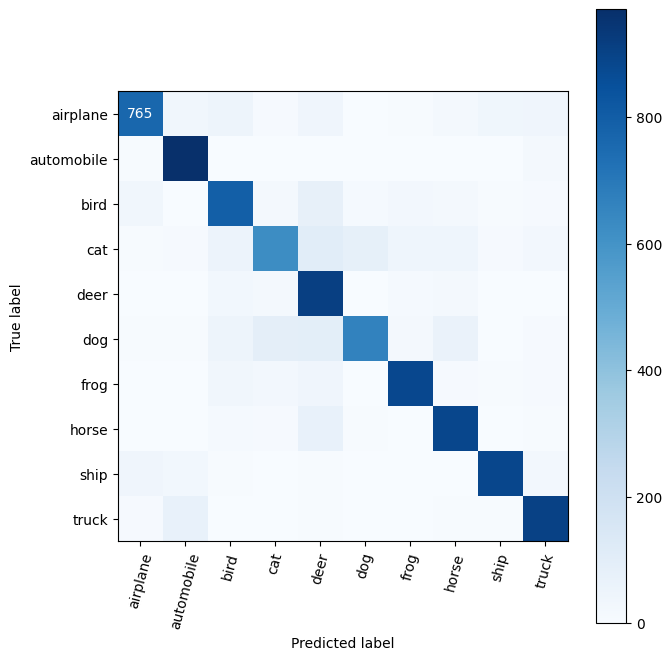

In [44]:
# 混同行列を描画
plot_confusion_matrix(y_test_class_names, y_pred_class_names)

モデルの構造を変えたことで正解率は83%まで向上しました。